In [1]:
import networkx as nx
import pandas as pd

In [2]:
import numpy as np
from random import random

In [185]:
class Tournament(object):
    def __init__(self):
        # team Data
        self.team_dict = {}
        # Completed fixture Data
        self.fixture_list = []
        # Pending fixture Data
        self.pending_fixture_list = []
        # Default seed
        self.max_seed = 0
        # Points for a win
        self.win_pts = 3
        #Points for a draw
        self.draw_pts = 1
        #Points for a bye
        self.bye_pts = 3
        # Matchday Count
        self.matchday = 0
        # Minimum Possible Pairings
        self.min_pairings = 20
        # Tiebreaker
        self.tiebreaker = 'sonneborn-berger'
    
    def add_team(self, name, seed = 'none', points = 0, more = {}):
        if seed == 'none':
            seed = self.max_seed
        
        self.team_dict[name] = {'seed': seed,
                                 'points': points,
                                 'opponents': [],
                                 'byes': 0, 
                                'sonneborn-berger': 0}
        
        self.team_dict[name].update(more)
    # Pair all teams with no extra restrictions
    def all_fixtures(self):
        self.matchday += 1
        teams_df = pd.DataFrame(self.team_dict).transpose().sample(frac = 1).sort_values(by = ['points','seed'], ascending = [False,True]).reset_index(names = 'name')
        self.create_fixtures(teams_df)
        
    def filtered_fixtures(self, filter_):
        self.matchday += 1
        teams_df = pd.DataFrame(self.team_dict).transpose().sample(frac = 1).sort_values(by = ['points','seed'], ascending = [False,True]).reset_index(names = 'name')
        teams_divided = [teams_df[teams_df[filter_] == x].reset_index(drop=True) for x in teams_df[filter_].drop_duplicates()]
        for teams in teams_divided:
            self.create_fixtures(teams)
        
    def create_fixtures(self, teams_df):    
        # Check whether a team needs to be given a bye
        byeNeeded = (len(teams_df) % 2 == 1)
        
        # Create a network graph
        G = nx.Graph()
        
        # Parameters for creating possible pairings
        team_count = len(teams_df)
        reach = max(int(team_count/(2**(self.matchday - 1))), self.min_pairings, self.matchday)
        step = max(int(reach/self.min_pairings), 1)
        
        # Add edges for each pairing of teams
        for row1 in teams_df.iterrows():
            idx = row1[0]
            data1 = row1[1]
            
            options = teams_df[idx + 1 : idx + reach : step]
            
            for row2 in options.iterrows():
                data2 = row2[1]
                
                ptsGap = abs(data1['points'] - data2['points'])
                seedGap = abs(data1['seed'] - data2['seed'])

                # weights are determined by number of previous meetings, points gap and seed gap
                weight = data1['opponents'].count(data2['name']) * 1000 + ptsGap - seedGap/1000
                G.add_edge(data1['name'], data2['name'], weight = weight)
            
            # Calculate bye weights if necessary
            if byeNeeded & (len(teams_df) - idx < 101):
                pts = data1['points']
                seed = data1['seed']
                byes = data1['byes']

                weight = byes*1000 + pts - seed/1000
                G.add_edge(data1['name'],'bye', weight = weight)
            
        # Conduct minumum weight matching
        fixtures = nx.algorithms.matching.min_weight_matching(G)
        
        # Add opponent to each team, and bye count for the team with a bye
        for fixture in fixtures:
            if 'bye' in fixture:
                for team in fixture:
                    if team != 'bye':
                        self.team_dict[team]['byes'] += 1
                        self.team_dict[team]['points'] += self.bye_pts
            else:
                team1, team2 = fixture[0], fixture[1]
                self.team_dict[team1]['opponents'].append(team2)
                self.team_dict[team2]['opponents'].append(team1)
                self.pending_fixture_list.append(fixture)
        
    
    def report_result(self, result, more = {}):
        # Result format: {team1: score1, team2: score2}
        
        teams = list(result.keys())
        totals = list(result.values())
        
        # Remove entry in pending fixture list
        for fixture in self.pending_fixture_list:
            if (teams[0] in fixture) & (teams[1] in fixture):
                self.pending_fixture_list.remove(fixture)
        
        # Interpret result and add points
        if totals[0] > totals[1]:
            res =  teams[0]
            self.team_dict[teams[0]]['points'] += self.win_pts
        elif totals[0] == totals[1]:
            res = 'draw'
            for team in teams:
                self.team_dict[team]['points'] += self.draw_pts
        else:
            res = teams[1]
            self.team_dict[teams[1]]['points'] += self.win_pts
        
        # Store fixture result in fixture list
        # Result format: {'Home': team1, 'score1': score1, 'score2': score2, 'Away': team2, 'Result': winning team/draw}
        result_dict = {'Home': teams[0], 'score1': totals[0], 'score2': totals[1], 'Away': teams[1], 'Result': res}
        result_dict.update(more)
        self.fixture_list.append(result_dict)
        
    def fixtures_df(self, team = ''):
        df = pd.DataFrame(self.fixture_list)
        if team != '':
            df = df[(df.Home == team) | (df.Away == team)]
        return df
    
    def league_table(self):
        self.sonneborn_berger()
        df = pd.DataFrame(self.team_dict).transpose().sample(frac = 1).sort_values(by = ['points', self.tiebreaker, 'seed'], ascending = [False,False,True]).reset_index(names = 'name')
        return df
    
    def filtered_league_tables(self, filter_ = 'country'):
        df = self.league_table()
        filter_categories = df[filter_].drop_duplicates()
        
        tables_dict = {}
        for cat in filter_categories:
            tables_dict[cat] = df[df[filter_] == cat].reset_index(drop=True)
        
        return tables_dict
    
    def sonneborn_berger(self):
        for team in self.team_dict:
            tiebreaker = 0
            fixture_df = self.fixtures_df()
            results = fixture_df[(fixture_df.Home == team) | (fixture_df.Away == team)].reset_index(drop = True).Result
            opponents = self.team_dict[team]['opponents']

            for opponent, result in zip(opponents, results):
                opp_points = self.team_dict[opponent]['points']

                if result == team:
                    tiebreaker += self.win_pts * opp_points
                elif result == 'draw':
                    tiebreaker += self.draw_pts * opp_points
            
            self.team_dict[team]['sonneborn-berger'] = tiebreaker

In [10]:
mymodel = np.poly1d([-0.63338287,  0.4410632 ,  0.08619369,  0.16459536])

In [11]:
def sim_fixtures(tournament):
    results = []

    for fixture in tournament.pending_fixture_list:
        team1, team2 = fixture[0], fixture[1]
        data1, data2 = tournament.team_dict[team1], tournament.team_dict[team2]
        elo1, elo2 = data1['elo'], data2['elo']

        score = sim_match(elo1, elo2)

        results.append({team1: score[0], team2: score[1]})
    
    return results

In [12]:
def sim_match(elo1, elo2):
    m = elo1 - elo2
    prob = 1/(1+10**(-m/400))

    draw_prob = mymodel(prob)
    win_prob = prob/(1-draw_prob)

    result = random()

    if win_prob - result > 0.00001:
        score = [1, 0]
    elif win_prob + draw_prob - result > 0.00001:
        score = [0.5, 0.5]
    else:
        score = [0, 1]
    
    return score

In [3]:
teams_data = pd.read_csv('teams_data.csv')

In [6]:
teams_data[10:50:2]

,Club,Elo,Country
10,11 Dortmund,1851,GER
12,13 Aston Villa,1844,ENG
14,15 Tottenham,1840,ENG
16,17 Napoli,1815,ITA
18,19 PSV,1811,NED
20,21 Newcastle,1804,ENG
22,23 Porto,1800,POR
24,25 Benfica,1796,POR
26,27 West Ham,1787,ENG
28,29 Sporting,1775,POR


In [186]:
to = Tournament()

In [187]:
for row in teams_data.iterrows():
    team = row[1].Club
    elo = row[1].Elo
    country = row[1].Country
    seed = row[0] + 1
    
    to.add_team(team, seed, more = {'elo': elo, 'country': country})

In [188]:
# Tournament simulator
season_length = 40

for n in range(1, season_length + 1):
    if n % 2 == 0:
        to.all_fixtures()
    else:
        teams_divided = to.filtered_fixtures('country')

    results = sim_fixtures(to)

    for result in results:
        to.report_result(result, more = {'matchday': n})
    
    print(n)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [189]:
league_table = to.league_table()

In [190]:
league_table

,name,seed,points,opponents,byes,sonneborn-berger,elo,country
0,1 Man City,1,100,"[Ipswich, დილა გორი, 53 Bournemouth, מכבי חיפה...",0,7421,2051,ENG
1,4 Inter,4,88,"[Parma, Guingamp, Venezia, 69 Ajax, 31 Lazio, ...",0,6300,1950,ITA
2,14 Milan,14,87,"[Lecco, Milsami, Catanzaro, Puskas Akademia, S...",0,6115,1843,ITA
3,2 Real Madrid,2,86,"[Burgos, Hartberg, 82 Celta, Bodø/Glimt, 10 Ba...",0,6203,1972,ESP
4,5 Liverpool,5,85,"[Sheffield United, Cosenza, 35 Brentford, 61 S...",0,6260,1947,ENG
...,...,...,...,...,...,...,...,...
626,Ivanjica,608,27,"[Cukaricki, Düsseldorf, Zlatibor, Widzew, Novi...",2,838,1066,SRB
627,Етър,600,24,"[Черно море, Урал, Левски, הפועל חיפה, Славия ...",1,627,1078,BUL
628,Локомотив София,577,24,"[ЦСКА София, Lugano, Славия София, Voluntari, ...",1,548,1120,BUL
629,Dukagjini,589,18,"[Drita, 52 Frankfurt, Ballkani, Pau, KF Gjilan...",1,539,1097,KOS


In [199]:
deltas = []

for idx, row in league_table.iterrows():
    team = row.name
    position = idx + 1
    seed = row.seed
    delta = position - seed
    deltas.append(delta)
    
league_table['position-seed delta'] = deltas 

In [212]:
league_table[:50]

,name,seed,points,opponents,byes,sonneborn-berger,elo,country,position-seed delta
0,1 Man City,1,100,"[Ipswich, დილა გორი, 53 Bournemouth, מכבי חיפה...",0,7421,2051,ENG,0
1,4 Inter,4,88,"[Parma, Guingamp, Venezia, 69 Ajax, 31 Lazio, ...",0,6300,1950,ITA,-2
2,14 Milan,14,87,"[Lecco, Milsami, Catanzaro, Puskas Akademia, S...",0,6115,1843,ITA,-11
3,2 Real Madrid,2,86,"[Burgos, Hartberg, 82 Celta, Bodø/Glimt, 10 Ba...",0,6203,1972,ESP,2
4,5 Liverpool,5,85,"[Sheffield United, Cosenza, 35 Brentford, 61 S...",0,6260,1947,ENG,0
5,6 Arsenal,6,85,"[Sheffield Weds, Vozdovac Beograd, 81 Burnley,...",0,6152,1931,ENG,0
6,3 Bayern,3,85,"[Hamburg, QPR, 73 Hoffenheim, 59 Fenerbahçe, 1...",0,6050,1954,GER,4
7,11 Dortmund,11,82,"[Nürnberg, Boavista, 77 Union Berlin, 67 Зенит...",0,5826,1851,GER,-3
8,9 Leverkusen,9,82,"[Braunschweig, Karvina, 66 Gladbach, Klaksvík,...",0,5743,1867,GER,0
9,19 PSV,19,81,"[Heerenveen, Rapid Wien, Alkmaar, Cercle Brugg...",0,5445,1811,NED,-9


In [214]:
league_tables_by_country = to.filtered_league_tables()

In [237]:
league_tables_by_country[25]

,name,seed,points,opponents,byes,sonneborn-berger,elo,country
0,Dinamo Zagreb,177,66,"[HNK Gorica, Со́чи, Varazdin, Ботев Враца, Rud...",0,3610,1513,CRO
1,Osijek,357,65,"[Varazdin, Mura, Lok Zagreb, Karvina, Hajduk, ...",0,3512,1375,CRO
2,Hajduk,212,64,"[Rudes Zagreb, Kisvarda, Istra 1961, Eupen, Os...",0,3468,1476,CRO
3,Rijeka,283,62,"[Istra 1961, 64 Sevilla, Rudes Zagreb, 77 Unio...",0,3240,1429,CRO
4,Lok Zagreb,376,57,"[Slaven Belupo, 27 West Ham, Osijek, Alkmaar, ...",0,2908,1363,CRO
5,HNK Gorica,441,54,"[Dinamo Zagreb, Sochaux, Slaven Belupo, Penybo...",0,2716,1309,CRO
6,Istra 1961,471,52,"[Rijeka, Bohemians Praha, Hajduk, Waalwijk, HN...",0,2562,1275,CRO
7,Slaven Belupo,461,46,"[Lok Zagreb, Heerenveen, HNK Gorica, Балтика, ...",0,2170,1287,CRO
8,Varazdin,472,45,"[Osijek, Nordsjælland, Dinamo Zagreb, Rapid Wi...",0,1955,1275,CRO
9,Rudes Zagreb,579,33,"[Hajduk, Le Havre, Rijeka, Neftçi, Dinamo Zagr...",1,1113,1118,CRO


C:\Users\Usamah\AppData\Local\Temp\ipykernel_3448\3747660786.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = league_table.groupby('country').mean()


<Axes: xlabel='margins', ylabel='position-seed delta'>

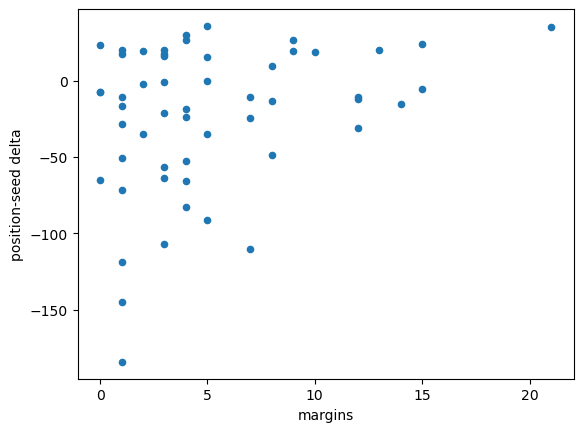

In [259]:
# Examining the relationship between league winning margin and average position-seed delta

winning_margin_dict = {}
for table in league_tables_by_country:
    country =  table['country'][0]
    if len(table) > 1:
        delta = table['points'][0] - table['points'][1]
        winning_margin_dict[country] = delta
    
df = league_table.groupby('country').mean()
margins = []
for idx, row in df.iterrows():
    try:
        margins.append(winning_margin_dict[idx])
    except:
        margins.append(None)

df['margins'] = margins
df.dropna(how = 'any')

df.dropna(how = 'any').plot(x = 'margins', y = 'position-seed delta',  kind = 'scatter')

In [264]:
df.sort_values(by = 'margins', ascending = False)

,position-seed delta,margins
country,,
AZE,35.000000,21.0
ENG,23.954545,15.0
LIT,-5.250000,15.0
MOL,-15.500000,14.0
RUS,20.187500,13.0
LAT,-10.500000,12.0
KAZ,-11.750000,12.0
IRL,-31.250000,12.0
NED,18.500000,10.0


C:\Users\Usamah\AppData\Local\Temp\ipykernel_3448\3719136059.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  league_table.groupby('country').mean().sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))


<Axes: xlabel='country'>

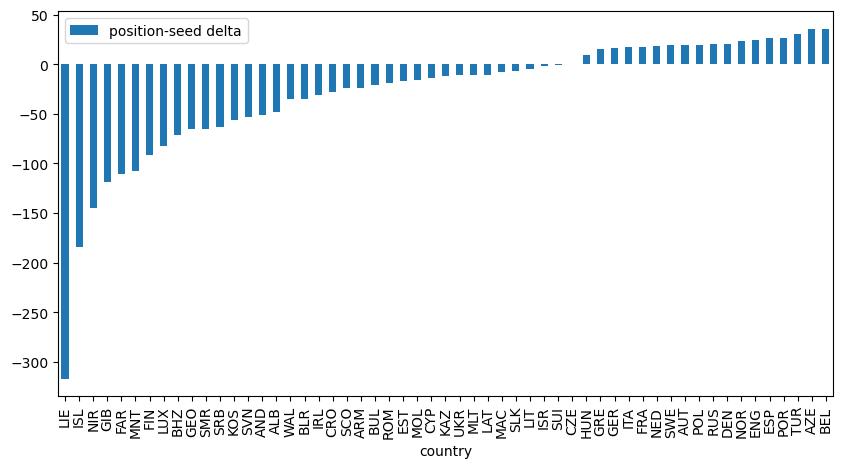

In [210]:
league_table.groupby('country').mean().sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))

In [195]:
league_table[league_table.byes > 1]

,name,seed,points,opponents,byes,sonneborn-berger,elo,country
100,Vaduz,418,68,"[79 FC København, 74 Monza, 26 Atalanta, 56 Sl...",20,550,1328,LIE
317,Víkingur,524,58,"[Akureyri, 25 Benfica, Breiðablik, Molde, Adan...",7,2086,1215,ISL
336,Akureyri,518,57,"[Víkingur, Suedtirol, Pisa, Breiðablik, Osijek...",7,1982,1224,ISL
369,Breiðablik,536,55,"[Palermo, Víkingur, Черно море, Akureyri, Փյու...",6,2110,1202,ISL
447,Arsenal Tivat,615,51,"[Podgorica, Utrecht, Sutjeska, Brann, Gaziante...",6,1499,1017,MNT
469,Lincoln,623,50,"[College Europa, Granada, FCB Magpies, Ferrol,...",6,1507,950,GIB
487,Tescoma Zlin,450,49,"[Mladá Boleslav, 91 Strasbourg, Hradec Králové...",2,2008,1299,CZE
488,College Europa,624,49,"[Lincoln, Casa Pia, Catanzaro, FCB Magpies, Du...",7,1316,907,GIB
499,Sutjeska,621,48,"[44 Marseille, Arsenal Tivat, Ростов, Podgoric...",7,1246,968,MNT
527,Karvina,483,46,"[Sigma Olomouc, 9 Leverkusen, Banik Ostrava, O...",2,1967,1258,CZE


<Axes: >

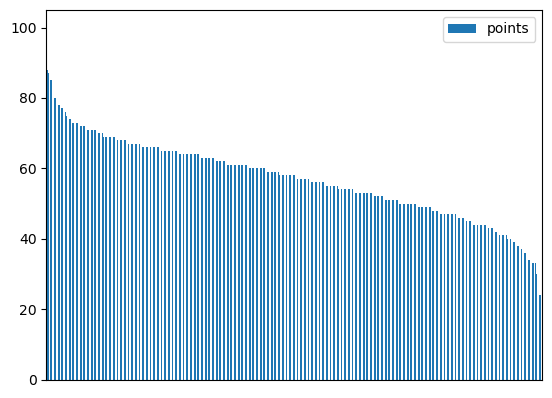

In [196]:
league_table.plot.bar(y = 'points', xticks = [])

<Axes: ylabel='Frequency'>

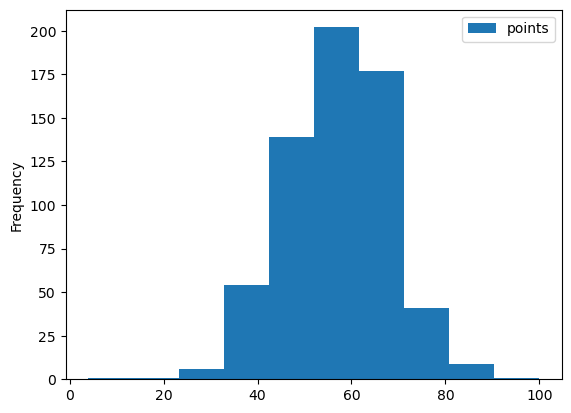

In [266]:
league_table.plot.hist(y = 'points')

In [273]:
league_table.groupby('country').mean(numeric_only = False).sort_values(by = 'points', ascending = False)

C:\Users\Usamah\AppData\Local\Temp\ipykernel_3448\646767022.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  league_table.groupby('country').mean(numeric_only = False).sort_values(by = 'points', ascending = False)


,seed,points,byes,sonneborn-berger,elo,position-seed delta
country,,,,,,
LIE,418.000000,68.000000,20.000000,550.000000,1328.000000,-317.000000
ENG,127.545455,66.977273,0.000000,4212.613636,1624.772727,23.954545
ESP,130.523810,65.666667,0.000000,4080.190476,1601.976190,26.476190
GER,154.111111,65.472222,0.000000,4014.583333,1581.027778,15.888889
ITA,167.325000,65.125000,0.000000,3993.275000,1569.800000,17.350000
FRA,202.051282,62.589744,0.512821,3608.871795,1525.153846,17.358974
BEL,191.125000,61.875000,0.000000,3554.687500,1522.687500,35.875000
CYP,249.750000,61.250000,0.000000,3492.750000,1448.250000,-13.500000
DEN,224.166667,61.166667,0.000000,3424.583333,1486.666667,20.250000


In [261]:
import pickle

with open ('TournamentV3_sample.pickle','wb') as file:
    pickle.dump(to, file)

In [280]:
False == 0

True

In [282]:
fixtures = to.fixtures_df()

upset_list = []

for idx, row in fixtures.iterrows():
    teams, result = [row.Home, row.Away], row.Result
    seeds = [to.team_dict[x]['seed'] for x in teams]
    
    home_advantage = seeds[0] < seeds[1]
    home_result = result == teams[0]
    
    if result == 'draw':
        text = 'draw'
    else:
        if home_advantage == home_result:
            text = 'hold'
        else:
            text = 'upset'
    upset_list.append(text)

In [305]:
fixtures['upset?'] = upset_list

rate_list = []
for n in range(1, 41):
    mask = fixtures['matchday'] == n
    result_rates = fixtures[mask].value_counts(subset = 'upset?')/sum(mask)
    rate_list.append(result_rates)

<Axes: >

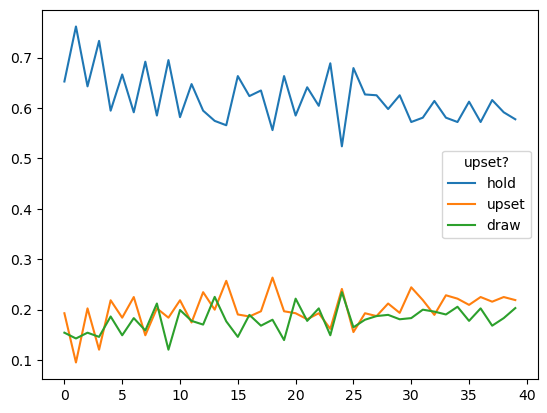

In [306]:
pd.DataFrame(rate_list).plot()